<h1> The Battle of Neighborhoods Code </h1>

In [81]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [82]:
#Loading data on housing prices and parliamentary constituencies
df_man = pd.read_csv('housing prices.csv', header = 0, encoding = "ISO-8859-1")
df_man.columns = ['Constituency', 'Median Purchase Price (£)']
df_man

,Constituency,Median Purchase Price (£)
0,Altrincham and Sale West,340000
1,Ashton-under-Lyne,135250
2,Blackley and Broughton,135000
3,Bolton North East,178000
4,Bolton South East,137125
5,Bolton West,155000
6,Bury North,159725
7,Bury South,180000
8,Cheadle,290000
9,Denton and Reddish,154500


In [83]:
with open('wpc.json') as json_data:
    manchester_json = json.load(json_data)

In [84]:
latitude = list()
longitude = list()
for i in range(len(manchester_json['features'])):
    point1 = manchester_json['features'][i]['geometry']['coordinates'][0][0]
    length = round(len(manchester_json['features'][i]['geometry']['coordinates'][0])/2)
    point2 = manchester_json['features'][i]['geometry']['coordinates'][0][length]
    lat = .5 * float(point1[1]) + .5 * float(point2[1])
    long = .5 * float(point1[0]) + .5 * float(point2[0])
    latitude.append(lat)
    longitude.append(long)

In [85]:
#Adding longitude and latitude to the dataframe
df_man['Latitude'] = latitude
df_man['Longitude'] = longitude
df_man.head()

,Constituency,Median Purchase Price (£),Latitude,Longitude
0,Altrincham and Sale West,340000,53.375973,-2.387981
1,Ashton-under-Lyne,135250,53.497954,-2.124014
2,Blackley and Broughton,135000,53.514415,-2.250754
3,Bolton North East,178000,53.607014,-2.421206
4,Bolton South East,137125,53.548310,-2.383467


In [86]:
#Getting venue information
CLIENT_ID = 'O01XON5X0HRHLTYIS21HGKLGFJXLEADJ0TRWK1HYKMMPEJ0M' # your Foursquare ID
CLIENT_SECRET = 'ZKG0YDR2I0I5I2ZZD3F4N4ZCR4SQN4QC4RQJBL251CMD1O5O' # your Foursquare Secret
VERSION = '20200209'
limit = 10000
radius = 4000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O01XON5X0HRHLTYIS21HGKLGFJXLEADJ0TRWK1HYKMMPEJ0M
CLIENT_SECRET:ZKG0YDR2I0I5I2ZZD3F4N4ZCR4SQN4QC4RQJBL251CMD1O5O


In [87]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [88]:
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(name)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Constituency', 
                  'Constituency Latitude', 
                  'Constituency Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [89]:
#If it fails, just retry - there's a bug that makes it sometimes fail, but normally if you rerun the block it'll work again
manchester_venues = getNearbyVenues(names=df_man['Constituency'], 
                                   latitudes=df_man['Latitude'],
                                   longitudes=df_man['Longitude']
                                  )
print('\n')
print('Number of unique venues:', len(manchester_venues['Venue Category'].unique()))

Altrincham and Sale West
Ashton-under-Lyne
Blackley and Broughton
Bolton North East
Bolton South East
Bolton West
Bury North
Bury South
Cheadle
Denton and Reddish
Hazel Grove
Heywood and Middleton
Leigh
Makerfield
Manchester Central
Manchester, Gorton
Manchester, Withington
Oldham East and Saddleworth
Oldham West and Royton
Rochdale
Salford and Eccles
Stalybridge and Hyde
Stockport
Stretford and Urmston
Wigan
Worsley and Eccles South
Wythenshawe and Sale East


Number of unique venues: 182


In [90]:
#one hot encoding variables
manchester_onehot = pd.get_dummies(manchester_venues[['Venue Category']], prefix="", prefix_sep="")
manchester_onehot['Constituency'] = manchester_venues['Constituency'] 
fixed_columns = [manchester_onehot.columns[-1]]+ list(manchester_onehot.columns[:-1])
manchester_onehot = manchester_onehot[fixed_columns]
manchester_onehot.head()

,Constituency,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Buffet,Burger Joint,Bus Stop,Café,Canal,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comic Shop,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Inn,Italian Restaurant,Japanese Restaurant,Jazz Club,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Outdoor Supply Store,Outlet Mall,Outlet Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Restaurant,Roller Rink,Rugby Stadium,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store
0,Altrincham and Sale West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Altrincham and Sale West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Altrincham and Sale West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Altrincham and Sale West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [91]:
#grouping by Borough
manchester_grouped = manchester_onehot.groupby('Constituency').mean().reset_index()
manchester_grouped.head()

,Constituency,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Buffet,Burger Joint,Bus Stop,Café,Canal,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comic Shop,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Inn,Italian Restaurant,Japanese Restaurant,Jazz Club,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Outdoor Supply Store,Outlet Mall,Outlet Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Restaurant,Roller Rink,Rugby Stadium,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store
0,Altrincham and Sale West,0.0,0.0,0.0,0.013514,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.067568,0.00,0.00,0.00,0.0,0.013514,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.027027,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.013514,0.013514,0.054054,0.0,0.0,0.00,0.013514,0.0,0.0,0.0,0.027027,0.013514,0.0,0.013514,0.000000,0.0,0.000000,0.013514,0.000000,0.0,0.0,0.013514,0.013514,0.000000,0.0,0.013514,0.0,0.0,0.000000,0.00,0.013514,0.00,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,0.0,0.013514,0.0,0.0,0.027027,0.000000,0.013514,0.013514,0.0,0.0,0.013514,0.013514,0.000000,0.0,0.0,0.0,0.027027,0.0,0.0,0.000000,0.0,0.0,0.0,0.040541,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.013514,0.0,0.013514,0.0,0.000000,0.0,0.013514,0.0,0.0,0.0,0.027027,0.0,0.0,0.00,0.000000,0.013514,0.00,0.040541,0.0,0.0,0.000000,0.0,0.013514,0.0,0.135135,0.0,0.00,0.00,0.0,0.0,0.027027,0.0,0.0,0.013514,0.000000,0.0,0.0,0.0,0.0,0.0,0.013514,0.0,0.000000,0.0,0.013514,0.00,0.000000,0.0,0.000000,0.013514,0.0,0.00,0.0,0.027027,0.00,0.00,0.0,0.027027,0.013514,0.0,0.013514,0.0,0.0,0.013514,0.000000,0.00,0.000000,0.000000,0.0,0.013514,0.013514,0.0,0.0
1,Ashton-under-Lyne,0.0,0.0,0.0,0.010638,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.021277,0.00,0.00,0.00,0.0,0.010638,0.0,0.010638,0.00,0.0,0.0,0.010638,0.010638,0.000000,0.0,0.010638,0.000000,0.0,0.010638,0.0,0.021277,0.000000,0.053191,0.0,0.0,0.00,0.000000,0.0,0.0,

In [92]:
#top 5 venues for each postal code
num_top_venues = 6

for hood in manchester_grouped['Constituency']:
    print("----"+hood+"----")
    temp = manchester_grouped[manchester_grouped['Constituency'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Altrincham and Sale West----
                venue  freq
0                 Pub  0.14
1                 Bar  0.07
2         Coffee Shop  0.05
3  Italian Restaurant  0.04
4         Pizza Place  0.04
5    Department Store  0.03


----Ashton-under-Lyne----
                    venue  freq
0             Supermarket  0.12
1                     Pub  0.09
2           Grocery Store  0.06
3             Coffee Shop  0.05
4    Fast Food Restaurant  0.05
5  Furniture / Home Store  0.04


----Blackley and Broughton----
                venue  freq
0         Coffee Shop  0.10
1                 Bar  0.09
2                 Pub  0.06
3                Café  0.05
4  Italian Restaurant  0.05
5            Tea Room  0.04


----Bolton North East----
                  venue  freq
0                   Pub  0.11
1        Clothing Store  0.08
2           Supermarket  0.07
3  Fast Food Restaurant  0.07
4           Pizza Place  0.06
5         Grocery Store  0.06


----Bolton South East----
                    venu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

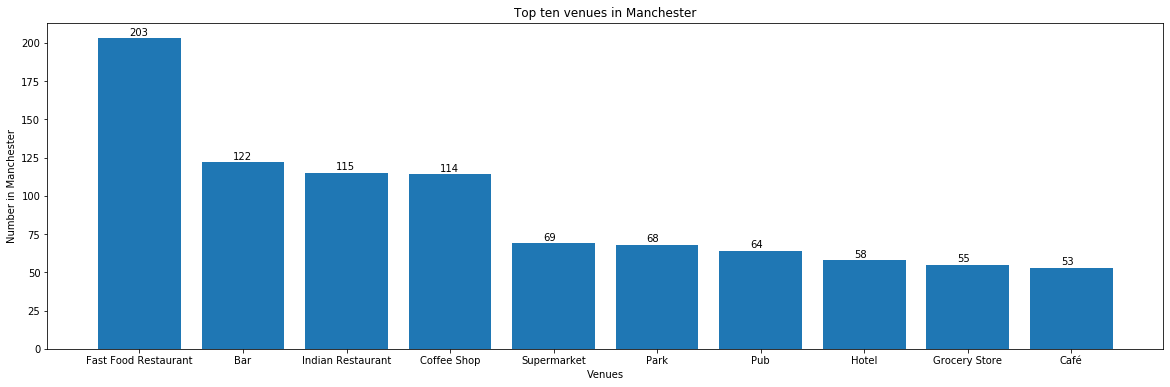

In [93]:
venues = manchester_onehot.columns[1:]
venue_count = {}
for i in venues:
    count = len(manchester_onehot[manchester_onehot[i] == 1])
    venue_count[i] = count
manchester_venues_count = pd.DataFrame.from_dict(venue_count, orient = 'index', columns = ['Number of Venues'])
manchester_venues_count = manchester_venues_count.sort_values(by = 'Number of Venues', ascending = False)
plt.figure(figsize = (20,6))
plt.bar(np.arange(10), manchester_venues_count['Number of Venues'].head(10))
plt.xticks(np.arange(10), set(manchester_venues_count.index[:10]))
for i in range(10):
    index = manchester_venues_count.index[i]
    num = manchester_venues_count.loc[index][0]
    plt.annotate(s = num, xy = (i-.1,num+2),color='black')
plt.xlabel('Venues')
plt.ylabel('Number in Manchester')
plt.title('Top ten venues in Manchester')
plt.show()

In [94]:
from scipy.spatial.distance import cdist 

In [120]:
#fitting kmeans model and identifying best k value
manchester_clustering_grouped = manchester_grouped.drop('Constituency', 1)
distortions = list()
kclusters = range(1,10)
for k in kclusters:
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(manchester_clustering_grouped)
    distortions.append(sum(np.min(cdist(manchester_clustering_grouped, kmeans.cluster_centers_, 
                      'euclidean'),axis=1)) / manchester_clustering_grouped.shape[0])
distortions

[0.13989360788337013,
 0.12634799703059374,
 0.11575308224594504,
 0.11037095932390742,
 0.10317281014187366,
 0.09585004090019904,
 0.0927113101250237,
 0.08586758434751,
 0.0766112471675777]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

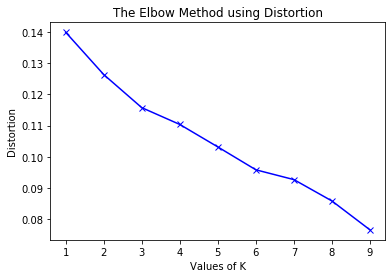

It appears that a k value of three is the best fit for this dataset


In [121]:
#Plotting distortion
plt.plot(kclusters, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()
print('It appears that a k value of three is the best fit for this dataset')

In [125]:
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(manchester_clustering_grouped)
kmeans.labels_

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 0], dtype=int32)

In [126]:
mapped_manchester = pd.DataFrame(columns = ['Constituency','Latitude','Longitude','Cluster'])
mapped_manchester['Constituency'] = df_man['Constituency']
mapped_manchester['Latitude'] = df_man['Latitude']
mapped_manchester['Longitude'] = df_man['Longitude']
mapped_manchester['Cluster'] = kmeans.labels_
mapped_manchester.head()

,Constituency,Latitude,Longitude,Cluster
0,Altrincham and Sale West,53.375973,-2.387981,0
1,Ashton-under-Lyne,53.497954,-2.124014,1
2,Blackley and Broughton,53.514415,-2.250754,0
3,Bolton North East,53.607014,-2.421206,1
4,Bolton South East,53.548310,-2.383467,1


In [136]:
geolocator = Nominatim(user_agent="manchester_explorer")
address = 'Manchester, England'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map that's clustered
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

kclusters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, .85, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map that are clustered
markers_colors = []
for lat, lon, constituency, cluster in zip(mapped_manchester['Latitude'], mapped_manchester['Longitude'], mapped_manchester['Constituency'], mapped_manchester['Cluster']):
    label = folium.Popup('Constituency: ' + 
                         str(constituency) + ', ' +
                         'Cluster: ' + 
                         str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [142]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [143]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Constituency']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Constituency'] = manchester_grouped['Constituency']


for ind in np.arange(manchester_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manchester_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Constituency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altrincham and Sale West,Pub,Bar,Coffee Shop,Pizza Place,Italian Restaurant,Café,Restaurant,Supermarket,Thai Restaurant,Grocery Store
1,Ashton-under-Lyne,Supermarket,Pub,Grocery Store,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Furniture / Home Store,Discount Store,Hotel,Italian Restaurant
2,Blackley and Broughton,Coffee Shop,Bar,Pub,Café,Italian Restaurant,Indian Restaurant,Tea Room,Restaurant,Grocery Store,Burger Joint
3,Bolton North East,Pub,Clothing Store,Fast Food Restaurant,Supermarket,Pizza Place,Grocery Store,Coffee Shop,Furniture / Home Store,Italian Restaurant,Gastropub
4,Bolton South East,Grocery Store,Fast Food Restaurant,Pub,Discount Store,Supermarket,Furniture / Home Store,Park,Gym,Thai Restaurant,Garden Center


In [144]:
neighborhoods_venues_sorted['Latitude'] = mapped_manchester['Latitude']
neighborhoods_venues_sorted['Longitude'] = mapped_manchester['Longitude']
neighborhoods_venues_sorted['Cluster'] = mapped_manchester['Cluster']
fixed_columns = [neighborhoods_venues_sorted.columns[0]]+ list(neighborhoods_venues_sorted.columns[-3:])+ list(neighborhoods_venues_sorted.columns[:-3])
fixed_columns = list(fixed_columns[:4]) + list(fixed_columns[5:])
neighborhoods_venues_sorted = neighborhoods_venues_sorted[fixed_columns]
neighborhoods_venues_sorted.head()

,Constituency,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altrincham and Sale West,53.375973,-2.387981,0,Pub,Bar,Coffee Shop,Pizza Place,Italian Restaurant,Café,Restaurant,Supermarket,Thai Restaurant,Grocery Store
1,Ashton-under-Lyne,53.497954,-2.124014,1,Supermarket,Pub,Grocery Store,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Furniture / Home Store,Discount Store,Hotel,Italian Restaurant
2,Blackley and Broughton,53.514415,-2.250754,0,Coffee Shop,Bar,Pub,Café,Italian Restaurant,Indian Restaurant,Tea Room,Restaurant,Grocery Store,Burger Joint
3,Bolton North East,53.607014,-2.421206,1,Pub,Clothing Store,Fast Food Restaurant,Supermarket,Pizza Place,Grocery Store,Coffee Shop,Furniture / Home Store,Italian Restaurant,Gastropub
4,Bolton South East,53.548310,-2.383467,1,Grocery Store,Fast Food Restaurant,Pub,Discount Store,Supermarket,Furniture / Home Store,Park,Gym,Thai Restaurant,Garden Center


In [145]:
#identifying the name and number of venues in a certain cluster
def venuesInCluster(cluster):
    cluster_constituencies = list(neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster'] == cluster]['Constituency'])
    cluster_filter = [True if constituency in cluster_constituencies else False for constituency in manchester_onehot['Constituency']]
    clustered_manchester_onehot = manchester_onehot[cluster_filter]
    venues = clustered_manchester_onehot.columns[1:]
    venue_count = {}
    for i in venues:
        count = len(clustered_manchester_onehot[clustered_manchester_onehot[i] == 1])
        venue_count[i] = count
    clustered_venues_count = pd.DataFrame.from_dict(venue_count, orient = 'index', columns = ['Number of Venues'])
    clustered_venues_count = clustered_venues_count.sort_values(by = 'Number of Venues', ascending = False)
    return clustered_venues_count

In [146]:
#it seems apt that we can categorize this as predominantly Coffee Shops/Cafe's and Pubs/Bars
clusterDescription = list()
clusterDescription.append('Coffeehouses and Alcoholic Establishments')
venuesInCluster(0).head()

,Number of Venues
Coffee Shop,45
Pub,41
Bar,38
Café,28
Park,25


In [148]:
#it seems apt that we categorize this as predominantly Pubs and Supermarkets/Grocery Stores
clusterDescription.append('Pubs and Marketplaces')
venuesInCluster(1).head()

,Number of Venues
Pub,155
Supermarket,110
Grocery Store,107
Coffee Shop,70
Fast Food Restaurant,48


In [151]:
#it seems apt that we categorize this as predominantly pubs
clusterDescription.append('Pubs')
venuesInCluster(2).head()

,Number of Venues
Pub,7
Grocery Store,3
Hotel,2
Airport,1
Bar,1


In [152]:
neighborhoods_venues_sorted['Cluster Description'] = [clusterDescription[i] for i in neighborhoods_venues_sorted['Cluster']]
fc = list(neighborhoods_venues_sorted.columns[:4]) + [neighborhoods_venues_sorted.columns[-1]] + list(neighborhoods_venues_sorted.columns[:-1][4:])
neighborhoods_venues_sorted = neighborhoods_venues_sorted[fc]

In [153]:
neighborhoods_venues_sorted.head()

,Constituency,Latitude,Longitude,Cluster,Cluster Description,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altrincham and Sale West,53.375973,-2.387981,0,Marketplaces,Pub,Bar,Coffee Shop,Pizza Place,Italian Restaurant,Café,Restaurant,Supermarket,Thai Restaurant,Grocery Store
1,Ashton-under-Lyne,53.497954,-2.124014,1,"Pubs, Marketplaces and Coffee Shops",Supermarket,Pub,Grocery Store,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Furniture / Home Store,Discount Store,Hotel,Italian Restaurant
2,Blackley and Broughton,53.514415,-2.250754,0,Marketplaces,Coffee Shop,Bar,Pub,Café,Italian Restaurant,Indian Restaurant,Tea Room,Restaurant,Grocery Store,Burger Joint
3,Bolton North East,53.607014,-2.421206,1,"Pubs, Marketplaces and Coffee Shops",Pub,Clothing Store,Fast Food Restaurant,Supermarket,Pizza Place,Grocery Store,Coffee Shop,Furniture / Home Store,Italian Restaurant,Gastropub
4,Bolton South East,53.548310,-2.383467,1,"Pubs, Marketplaces and Coffee Shops",Grocery Store,Fast Food Restaurant,Pub,Discount Store,Supermarket,Furniture / Home Store,Park,Gym,Thai Restaurant,Garden Center


In [154]:
manchester_data = neighborhoods_venues_sorted.copy()

In [155]:
print(df_man['Median Purchase Price (£)'].sort_values().head(1))
print(df_man['Median Purchase Price (£)'].sort_values().tail(1))

18    126500
Name: Median Purchase Price (£), dtype: int64
0    340000
Name: Median Purchase Price (£), dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

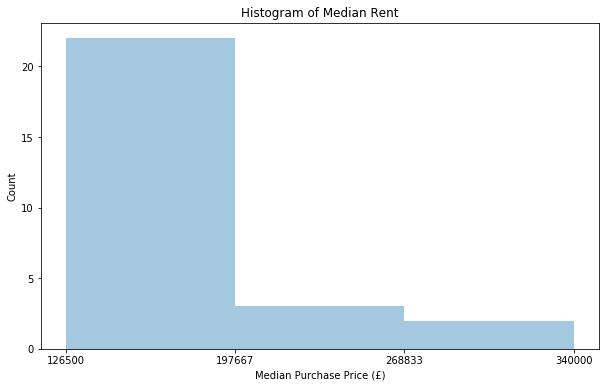

In [156]:
plt.figure(figsize = (10,6))
sns.distplot(df_man['Median Purchase Price (£)'], kde = False, bins = 3)
lower = df_man['Median Purchase Price (£)'].min()
upper = df_man['Median Purchase Price (£)'].max()
plt.xticks(np.arange(lower,upper+(upper-lower)/4,(upper-lower)/3))
plt.ylabel('Count')
plt.title('Histogram of Median Rent')
plt.show()

In [157]:
for i in range(3):
    print('Rent bracket', str(i+1) + ':', str('$') + str(round(lower+(i)*(upper-lower)/3,1)), 'to', str('$') + str(round(lower+(i+1)*(upper-lower)/3,1)))

Rent bracket 1: $126500.0 to $197666.7
Rent bracket 2: $197666.7 to $268833.3
Rent bracket 3: $268833.3 to $340000.0


In [158]:
manchester_geo = r'wpc.json'

In [159]:
threshold_scale = np.linspace(df_man['Median Purchase Price (£)'].min(), df_man['Median Purchase Price (£)'].max(), 4, dtype=int)
threshold_scale=list(threshold_scale)
threshold_scale[-1]=threshold_scale[-1]+1
latitude = location.latitude
longitude = location.longitude
manchester_map=folium.Map(location=[latitude,longitude],zoom_start=10)
manchester_map.choropleth(geo_data=manchester_geo,
                        data=df_man,
                        columns=['Constituency','Median Purchase Price (£)'],
                        key_on='feature.properties.PCON13NM',
                        threshold_scale=threshold_scale,
                        fill_color='YlOrRd',
                        fill_opacity=.7,
                        line_opacity=.2,
                        legend_name='Median House Purchase Price (£)',
                        reset=True)
manchester_map

In [160]:
# create map that's clustered
kclusters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**3 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, .85, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map that are clustered
markers_colors = []
for lat, lon, constituency, cluster, cluster_desc in zip(manchester_data['Latitude'], manchester_data['Longitude'], manchester_data['Constituency'], manchester_data['Cluster'], manchester_data['Cluster Description']):
    label = folium.Popup(str(constituency) + ', ' +
                         'Cluster ' + 
                         str(cluster) + ', ' +
                         'Most Frequent Venues: ' +
                         str(cluster_desc), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(manchester_map)
manchester_map